# Ships added mass in a berthing manoeuvre
## Inifinite water case - Lewis ship

Computation of the added mass coefficient for Lewis ship (dimensionless ship)!

In [1]:
import sympy as sym
#from sympy import Function, Symbol
import sage

import scipy.special as sci_spc
import scipy.integrate as sci_int
import numpy as np
import math as mat
import cmath as cmat
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import csv

# NUMBA
from numba import jit

# MatPlotLib set LaTeX font
plt.rcParams['text.usetex'] = True

In [2]:
def lewis_coeff(rbt,bts):
    
    B = bts[0]*rbt
    T = bts[1]
    S = B*T*bts[2]

    #print('B={:.2f}, T={:.2f}, S={:.4f}'.format(B,T,S))
    
    si = S/(B*T)
    H = B/(2*T)
    
    c1 = (3+4*si/mat.pi) + (1-4*si/mat.pi)*((H-1)/(H+1))**2
    a3 = (-c1 + 3 + mat.sqrt(9-2*c1))/c1
    a1 = (1 + a3)*(H-1)/(H+1)
    a = B/2 * (1 + a1 + a3)
    
    return correct_draft([a, a1, a3],T)

def correct_draft(cf,T):
    
    cf_n = cf
    [x,y] = lewis_point(cf,0)
    ts = T/y
    
    cf_n[0] = cf_n[0]*ts
    
    return cf_n

def lewis_map(cf,z):
    
    a = cf[0]
    a1 = cf[1]
    a3 = cf[2]
    
    w = a*(z + a1/z + a3/z**3)
    return w

def lewis_point(cf,th):
    
    a = cf[0]
    a1 = cf[1]
    a3 = cf[2]
    
    x = a*( (1+a1)*np.sin(th) - a3*np.sin(3*th))
    y = a*( (1-a1)*np.cos(th) + a3*np.cos(3*th))
    
    return [x,y]

In [3]:
def calculate_added_mass(bts,rbt,intf):
    
    # obtain form Lewis coefficients
    sb = rbt/2 # scailing factor (if different B/T than 2)
    cf = lewis_coeff(sb,bts)
    
    # Solve for unit speed U=1
    int_f_p = int_f.subs({rh:1,c0:cf[0],c1:cf[1],c3:cf[2]})
    ffx = (int_f_p).subs(th,x)
    fnc = sym.lambdify(x, ffx, 'numpy')
    
    # added mass coefficient for frame
    S = (bts[0]*sb) * bts[1] * bts[2]
    c22_int = 2*sci_int.quad(fnc, 0, mat.pi/2)[0]
    
    # Return nondimensional added mass coefficient and
    # nondimensional UKC (scaled by draft)
    return [c22_int,S]

In [4]:
sym.init_printing()

In [5]:
x,y,h = sym.symbols('x y h', real=True)
rh,th = sym.symbols('rho theta', real=True)
z = sym.symbols('z', complex=True)
c0,c1,c3 = sym.symbols('c_0 c_1 c_3', real=True)

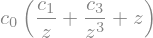

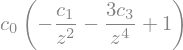

In [6]:
#cp = (2*h)/sym.pi * sym.sinh(sym.pi/(2*h))**2 * sym.coth(sym.pi*z/(2*h))
cp = 1/z
#
w = c0*(z+c1/z+c3/z**3)
g = sym.I*sym.exp(-sym.I*th)
#
dwdz = w.diff(z)
#
display(cp)
display(w)
display(g)
display(dwdz)

In [7]:
# Expand potential in series for checking process
#f = cp.series(z,0,6).removeO()

# Else put it as the original function
f = cp

display(f)

# Calculate the real part phi
phi = sym.re(f.subs(z,sym.I*sym.exp(-sym.I*th))).simplify()
display(phi)

Text(0.5, 1.0, 'Velocity potential $\\phi$')

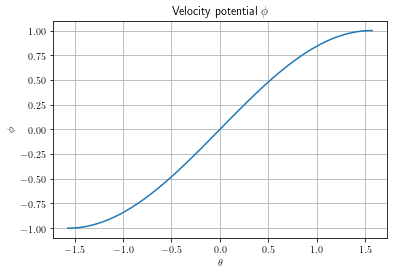

In [8]:
# Plot real part of the complex velocity potential
#

pp_x = []
th_v = np.linspace(-mat.pi/2,mat.pi/2,100)
fig, ax = plt.subplots()
for tt in th_v:
    pp_x.append(phi.subs(h,1.1).subs(th,tt))
pp_x = np.array(pp_x, dtype=float)

ax.plot(th_v,pp_x)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\phi$')
ax.grid(True)
plt.title(r'Velocity potential $\phi$')

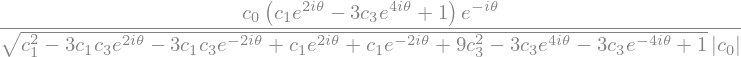

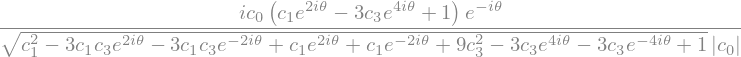

In [9]:
# Tangent and Normal vector in W space desctibed in Z
tv = (w.diff(z).subs(z,g)*g.diff(th))
tv = tv/sym.Abs(tv)
nv = sym.I*tv

display(tv)
display(nv)

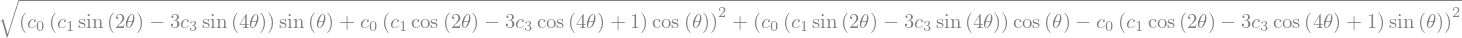

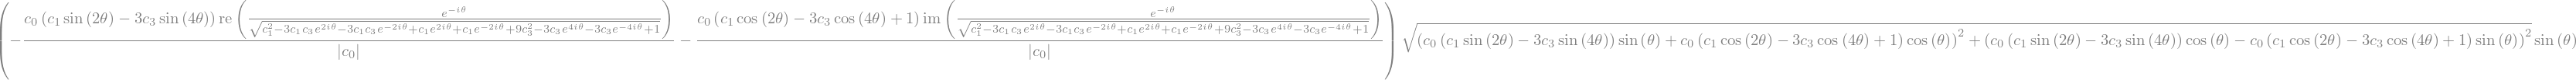

In [10]:
nx = sym.re(nv)
ny = sym.im(nv)

jac = dwdz.subs(z,g) * g.diff(th)
abs_jac = sym.sqrt(sym.re(jac)**2 + sym.im(jac)**2)
int_f = phi * nx * abs_jac

display(jac)
display(abs_jac)
display(int_f)

Text(0.5, 1.0, 'Integral function')

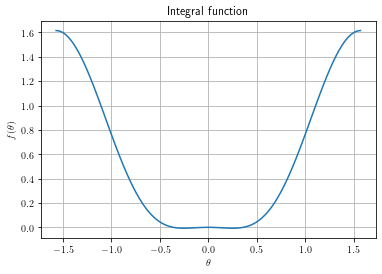

In [11]:
# Plot of added mass coefficient function for a specific cross section
#
cf = lewis_coeff(1,[2.0,1.0,0.99,0.60])
int_f_p = int_f.subs({rh:1,c0:cf[0],c1:cf[1],c3:cf[2]})
ffx = (int_f_p).subs(th,x)
fnc = sym.lambdify(x, ffx, 'numpy')

fip = []
th_v = np.linspace(-mat.pi/2,mat.pi/2,100)
fig, ax = plt.subplots()
for tt in th_v:
    fip.append(fnc(tt))
fip = np.array(fip, dtype=float)

ax.plot(th_v,fip)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$f(\theta)$')
ax.grid(True)
plt.title(r'Integral function')

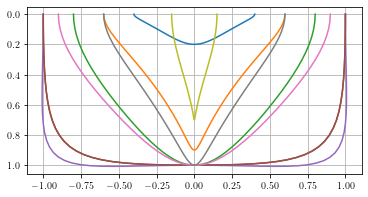

In [12]:
# Unified tanker shape [B,T,si,li]
# B  - cross section breadth
# T  - cross section draft
# si - cross section unit surface
# li - cross section length
#
# Article: Values are in Table 1
#

BTsi = [
    [0.8,0.2,0.6,0.05],
    [1.2,0.9,0.5,0.05],
    [1.6,1.0,0.68,0.05],
    [2.0,1.0,0.93,0.05],
    [2.0,1.0,0.99,0.60],
    [2.0,1.0,0.93,0.05],
    [1.8,1.0,0.68,0.05],
    [1.2,1.0,0.56,0.05],
    [0.3,0.7,0.56,0.05]
]
    
Nbts = len(BTsi)

thv = np.linspace(-mat.pi/2,mat.pi/2,50)
fig, ax = plt.subplots()
for i in range(Nbts):
    cf = lewis_coeff(1,BTsi[i])
    [xp, yp] = lewis_point(cf,thv)
    ax.plot(xp,yp)

ax.set_aspect(aspect=1)
ax.grid(True)
fig.gca().invert_yaxis()

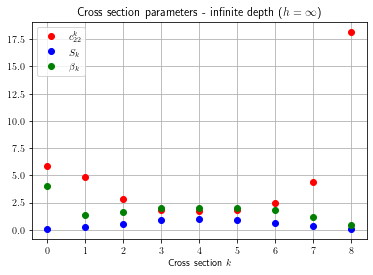

In [13]:
# *************************************************
# *** Start calculation added mass coefficients ***
# *** beta = 1                                  ***
# *************************************************
#

rdata = []
for i in range(9):
    ccr = calculate_added_mass(BTsi[i],1,int_f)
    rdata.append([i,ccr[0]/ccr[1],ccr[1],BTsi[i][0]/BTsi[i][1]])
rdata = np.array(rdata, dtype=float)

fig, ax = plt.subplots()

ax.plot(rdata[:,0],rdata[:,1], 'ro', label=r'$c_{22}^k$')
ax.plot(rdata[:,0],rdata[:,2], 'bo', label=r'$S_k$')
ax.plot(rdata[:,0],rdata[:,3], 'go', label=r'$\beta_k$')
ax.legend()
ax.set_xlabel(r'Cross section $k$')
ax.grid(True)
plt.title(r'Cross section parameters - infinite depth ($h=\infty$)')
fig.savefig('result_LCS_params.pdf')

In [14]:
# *************************************************
# *** Start calculation added mass coefficients ***
# *** beta = 2,3,4,5,6,7,8                      ***
# *************************************************
#

beta = [2,3,4,5,6,7,8]
data = []

for b in beta:
    
    c22s = 0
    V = 0
    print('beta={}'.format(b))
    for i in range(9):
        ccr = calculate_added_mass(BTsi[i],b,int_f)
        cam = ccr[0]*BTsi[i][3]
        V = V + ccr[1]*BTsi[i][3]
        c22s = c22s + cam
        print(' -> {}: c22={:.3f}, S={:.3f}, V={:.3f}'.format(i,ccr[0],ccr[1],ccr[1]*BTsi[i][3]))
    data.append([c22s,V])
    
data = np.array(data, dtype=float)
c22b = np.divide(data[:,0],data[:,1])

beta=2
 -> 0: c22=0.269, S=0.096, V=0.005
 -> 1: c22=1.235, S=0.540, V=0.027
 -> 2: c22=1.483, S=1.088, V=0.054
 -> 3: c22=1.732, S=1.860, V=0.093
 -> 4: c22=1.813, S=1.980, V=1.188
 -> 5: c22=1.732, S=1.860, V=0.093
 -> 6: c22=1.477, S=1.224, V=0.061
 -> 7: c22=1.420, S=0.672, V=0.034
 -> 8: c22=1.048, S=0.118, V=0.006
beta=3
 -> 0: c22=0.263, S=0.144, V=0.007
 -> 1: c22=1.192, S=0.810, V=0.041
 -> 2: c22=1.463, S=1.632, V=0.082
 -> 3: c22=1.763, S=2.790, V=0.140
 -> 4: c22=1.858, S=2.970, V=1.782
 -> 5: c22=1.763, S=2.790, V=0.140
 -> 6: c22=1.457, S=1.836, V=0.092
 -> 7: c22=1.381, S=1.008, V=0.050
 -> 8: c22=1.030, S=0.176, V=0.009
beta=4
 -> 0: c22=0.259, S=0.192, V=0.010
 -> 1: c22=1.159, S=1.080, V=0.054
 -> 2: c22=1.448, S=2.176, V=0.109
 -> 3: c22=1.783, S=3.720, V=0.186
 -> 4: c22=1.886, S=3.960, V=2.376
 -> 5: c22=1.783, S=3.720, V=0.186
 -> 6: c22=1.443, S=2.448, V=0.122
 -> 7: c22=1.352, S=1.344, V=0.067
 -> 8: c22=1.014, S=0.235, V=0.012
beta=5
 -> 0: c22=0.256, S=0.240, 

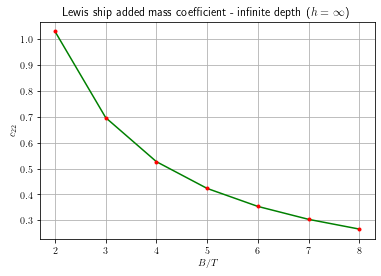

In [15]:
fig, ax = plt.subplots()

ax.plot(beta,c22b, 'g-')
ax.plot(beta,c22b, 'r.')
ax.set_xlabel(r'$B/T$')
ax.set_ylabel(r'$c_{22}$')
ax.grid(True)
plt.title(r'Lewis ship added mass coefficient - infinite depth ($h=\infty$)')
fig.savefig('result_beta_c22_inf.pdf')